In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

In [61]:
carbon_df = pd.read_csv('Semarang_Carbon_Stock.csv')

In [62]:
carbon_df.head()

,system:index,CA,CB,CS,latitude,longitude,.geo
0,0,50.765053,12.045225,6,-7.496441,110.658968,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,46.980125,11.828725,5,-7.487458,110.605069,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,46.319200,11.608475,5,-7.487458,110.614053,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3,35.962925,8.888200,5,-7.487458,110.623036,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4,33.521976,8.316850,5,-7.487458,110.632019,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [63]:
carbon_df = carbon_df[['CA', 'CB', 'CS', 'latitude', 'longitude']]

In [64]:
carbon_df.dtypes

CA           float64
CB           float64
CS             int64
latitude     float64
longitude    float64
dtype: object

In [65]:
carbon_df['CA'] = carbon_df['CA'].replace({r'\.': ''}, regex=True).astype(float)
carbon_df['CB'] = carbon_df['CB'].replace({r'\.': ''}, regex=True).astype(float)
carbon_df['CS'] = carbon_df['CS'].replace({r'\.': ''}, regex=True).astype(float)

In [66]:
carbon_df.isnull().sum() 

CA           0
CB           0
CS           0
latitude     0
longitude    0
dtype: int64

In [67]:
carbon_df.head()

,CA,CB,CS,latitude,longitude
0,50.765053,12.045225,6.0,-7.496441,110.658968
1,46.980125,11.828725,5.0,-7.487458,110.605069
2,46.319200,11.608475,5.0,-7.487458,110.614053
3,35.962925,8.888200,5.0,-7.487458,110.623036
4,33.521976,8.316850,5.0,-7.487458,110.632019


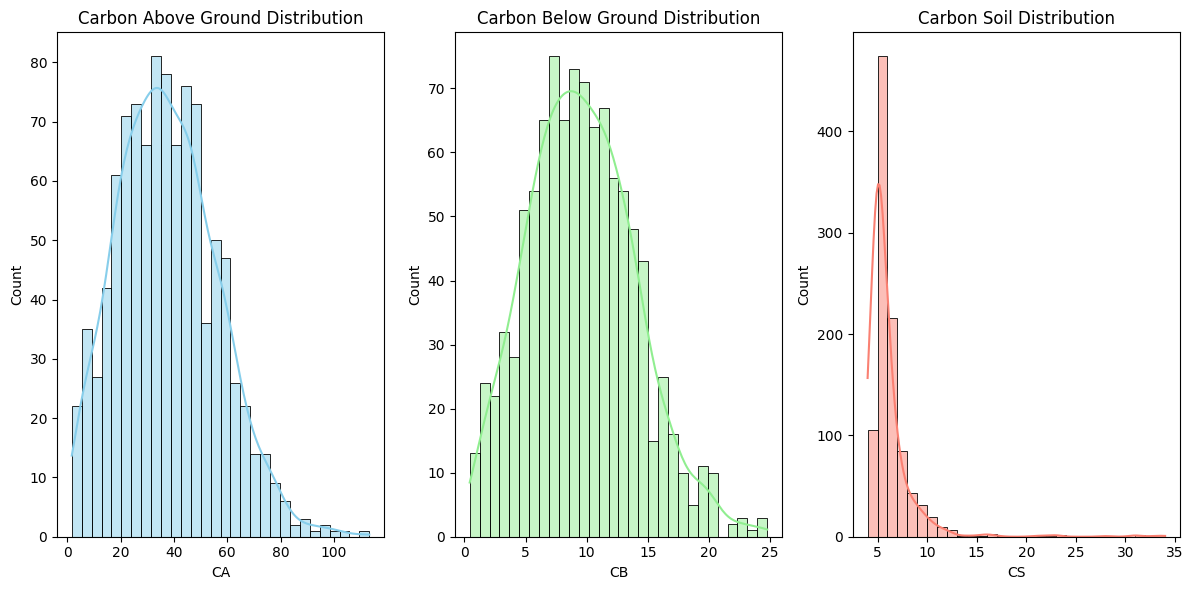

In [68]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(carbon_df['CA'], kde=True, bins=30, color='skyblue')
plt.title('Carbon Above Ground Distribution')

plt.subplot(1, 3, 2)
sns.histplot(carbon_df['CB'], kde=True, bins=30, color='lightgreen')
plt.title('Carbon Below Ground Distribution')

plt.subplot(1, 3, 3)
sns.histplot(carbon_df['CS'], kde=True, bins=30, color='salmon')
plt.title('Carbon Soil Distribution')

plt.tight_layout()
plt.show()

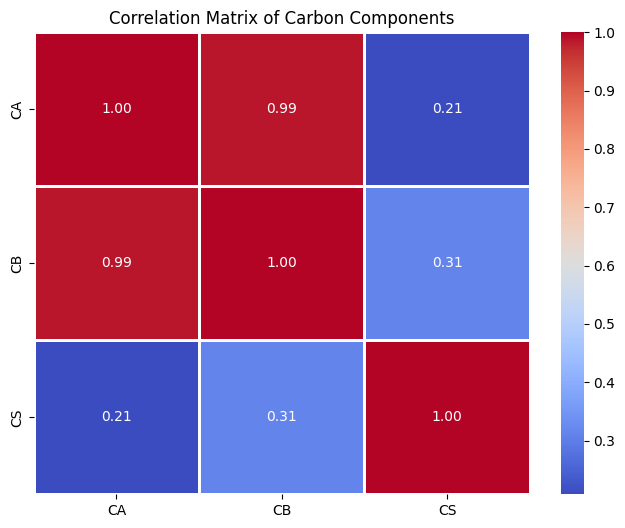

In [69]:
correlation_matrix = carbon_df[['CA', 'CB', 'CS']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, cbar=True)
plt.title('Correlation Matrix of Carbon Components')
plt.show()

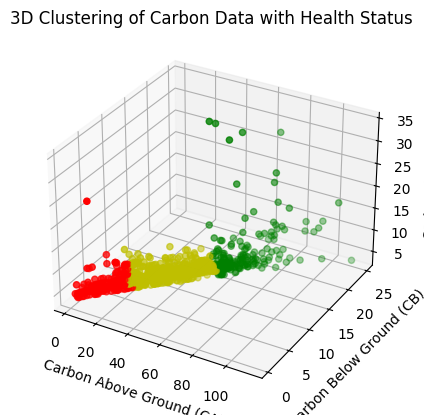

          CA         CB   CS  latitude   longitude CA_status CB_status  \
0  50.765053  12.045225  6.0 -7.496441  110.658968  moderate  moderate   
1  46.980125  11.828725  5.0 -7.487458  110.605069  moderate  moderate   
2  46.319200  11.608475  5.0 -7.487458  110.614053  moderate  moderate   
3  35.962925   8.888200  5.0 -7.487458  110.623036  moderate  moderate   
4  33.521976   8.316850  5.0 -7.487458  110.632019  moderate  moderate   

  CS_status Overall_status Color  
0  moderate         yellow     y  
1  moderate         yellow     y  
2  moderate         yellow     y  
3  moderate         yellow     y  
4  moderate         yellow     y  


In [70]:
threshold_CA_low = np.percentile(carbon_df['CA'], 20) 
threshold_CA_high = np.percentile(carbon_df['CA'], 80)

threshold_CB_low = np.percentile(carbon_df['CB'], 20)
threshold_CB_high = np.percentile(carbon_df['CB'], 80)

threshold_CS_low = np.percentile(carbon_df['CS'], 20)
threshold_CS_high = np.percentile(carbon_df['CS'], 80)

carbon_df['CA_status'] = np.where(carbon_df['CA'] > threshold_CA_high, 'good',
                                   np.where(carbon_df['CA'] < threshold_CA_low, 'bad', 'moderate'))

carbon_df['CB_status'] = np.where(carbon_df['CB'] > threshold_CB_high, 'good',
                                   np.where(carbon_df['CB'] < threshold_CB_low, 'bad', 'moderate'))

carbon_df['CS_status'] = np.where(carbon_df['CS'] > threshold_CS_high, 'good',
                                   np.where(carbon_df['CS'] < threshold_CS_low, 'bad', 'moderate'))

def overall_status(row):
    good_count = row[['CA_status', 'CB_status', 'CS_status']].value_counts().get('good', 0)
    bad_count = row[['CA_status', 'CB_status', 'CS_status']].value_counts().get('bad', 0)
    
    if good_count >= 2:
        return 'green'
    elif bad_count >= 2:
        return 'red'
    else:
        return 'yellow'

carbon_df['Overall_status'] = carbon_df.apply(overall_status, axis=1)

carbon_df['Color'] = carbon_df['Overall_status'].map({'green': 'g', 'yellow': 'y', 'red': 'r'})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(carbon_df['CA'], carbon_df['CB'], carbon_df['CS'], c=carbon_df['Color'])

ax.set_xlabel('Carbon Above Ground (CA)')
ax.set_ylabel('Carbon Below Ground (CB)')
ax.set_zlabel('Carbon Soil (CS)')

ax.set_title('3D Clustering of Carbon Data with Health Status')

plt.show()

print(carbon_df.head())

In [71]:

sampled_df = carbon_df.sample(500)

m = folium.Map(location=[sampled_df['latitude'].mean(), sampled_df['longitude'].mean()], zoom_start=6)

for idx, row in sampled_df.iterrows():
    color = row['Overall_status']
    color_map = {'green': 'green', 'yellow': 'yellow', 'red': 'red'}
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        color=color_map.get(color, 'gray'),
        fill=True,
        fill_color=color_map.get(color, 'gray'),
        fill_opacity=0.7,
        popup=f"Cluster: {color} <br> CA: {row['CA']} <br> CB: {row['CB']} <br> CS: {row['CS']}"
    ).add_to(m)

m